# Train an E(3)NN model to predict phonon density of states (DoS) from crystal structures

The E(3)NN version used in this notebook is `e3nn=0.0.0`, available [here](https://github.com/e3nn/e3nn/tree/0.0.0)

In [1]:
import torch
import torch_geometric
import torch_scatter

import e3nn
from e3nn import rs, o3
from e3nn.point.data_helpers import DataPeriodicNeighbors
from e3nn.networks import GatedConvParityNetwork
from e3nn.kernel_mod import Kernel
from e3nn.point.message_passing import Convolution

import pymatgen
from pymatgen.core.structure import Structure
import numpy as np
import time, os
import datetime
import pickle
from pymatgen.core.periodic_table import Element
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print('torch device:' , device)

torch device: cuda:7


### Define model parameters

In [2]:
params = {'len_embed_feat': 64,
          'num_channel_irrep': 32,
          'num_e3nn_layer': 2,
          'max_radius': 5,
          'num_basis': 10,
          'adamw_lr': 0.005,
          'adamw_wd': 0.05
         }
print('Length of embedding feature vector: {:3d} \n'.format(params.get('len_embed_feat')) + 
      'Number of channels per irreducible representation: {:3d} \n'.format(params.get('num_channel_irrep')) +
      'Number of tensor field convolution layers: {:3d} \n'.format(params.get('num_e3nn_layer')) + 
      'Maximum radius: {:3.1f} \n'.format(params.get('max_radius')) +
      'Number of basis: {:3d} \n'.format(params.get('num_basis')) +
      'AdamW optimizer learning rate: {:.4f} \n'.format(params.get('adamw_lr')) + 
      'AdamW optimizer weight decay coefficient: {:.4f}'.format(params.get('adamw_wd'))
     )

params_name = ('_len51max1000_fwin101ord3')

Length of embedding feature vector:  64 
Number of channels per irreducible representation:  32 
Number of tensor field convolution layers:   2 
Maximum radius: 5.0 
Number of basis:  10 
AdamW optimizer learning rate: 0.0050 
AdamW optimizer weight decay coefficient: 0.0500


### Assign model saving path

In [3]:
par_directory = 'models/'+time.strftime("%y%m%d", time.localtime())
if not os.path.isdir(par_directory):
    os.mkdir(par_directory)
run_name = ('models/'+time.strftime("%y%m%d", time.localtime())+'/'+time.strftime("%y%m%d-%H%M", time.localtime())
            +params_name)
print("Saving at directory: "+run_name)

Saving at directory: models/210114/210114-2220_len51max1000_fwin101ord3


### Prepare dataset

The following information is curated from the dataset presented in 
[Petretto, Guido, et al. "High-throughput density-functional perturbation theory phonons for inorganic materials." Scientific data 5 (2018): 180065.](https://www.nature.com/articles/sdata201865)

- `material_id`: Materials Project ID for each material
- `cif`: CIF files in strings
- `phfre`: Low resolution phonon frequency points, $\omega\in[0,1000]\,\text{cm}^{-1}$ and $\Delta \omega=20\,\text{cm}^{-1}$
- `phdos`: Low resolution phonon DoS interpolated from `phdos_gt` with `scipy.signal.savgol_filter` (`window_length=101` and `polyorder=3`)
- `phfre_gt`: High resolution phonon frequency points $\omega\in[0,4404]\,\text{cm}^{-1}$ and $\Delta \omega\approx1\,\text{cm}^{-1}$
- `phdos_gt`: High resolution interpolation phonon DoS 

In [4]:
with open('models/phdos_e3nn_len51max1000_fwin101ord3.pkl', 'rb') as f:
    data_dict = pickle.load(f)
print(data_dict.keys())

dict_keys(['material_id', 'cif', 'phfre', 'phdos', 'phfre_gt', 'phdos_gt'])


In [5]:
material_id = data_dict['material_id']
cif = data_dict['cif']
phfre = data_dict['phfre']
phdos = data_dict['phdos']
phfre_gt = data_dict['phfre_gt']
phdos_gt = data_dict['phdos_gt']

In [6]:
len(cif)

1524

In [7]:
phdos = torch.tensor(phdos)
structures = [Structure.from_str("\n".join(c), "CIF") for c in cif]

species = set()
for struct in structures[:]:
    species = species.union(list(set(map(str, struct.species))))
species = sorted(list(species))
print("Distinct atomic species ", len(species))

Distinct atomic species  64


### Define an E(3)NN model

In [8]:
len_element = 118
atom_types_dim = len_element
embedding_dim = params['len_embed_feat']
len_dos = phdos.shape[1]
lmax = 1
n_norm = 40  # Roughly the average number (over entire dataset) of nearest neighbors for a given atom

Rs_in = [(embedding_dim, 0, 1)]  # num_atom_types scalars (L=0) with even parity
Rs_out = [(len_dos, 0, 1)]  # len_dos scalars (L=0) with even parity

model_kwargs = {
    "convolution": Convolution,
    "kernel": Kernel,
    "Rs_in": Rs_in,
    "Rs_out": Rs_out,
    "mul": params['num_channel_irrep'], # number of channels per irrep (differeing L and parity)
    "layers": params['num_e3nn_layer'],
    "max_radius": params['max_radius'],
    "lmax": lmax,
    "number_of_basis": params['num_basis']
}
print(model_kwargs)
class AtomEmbeddingAndSumLastLayer(torch.nn.Module):
    def __init__(self, atom_type_in, atom_type_out, model):
        super().__init__()
        self.linear = torch.nn.Linear(atom_type_in, atom_type_out)
        self.model = model
        self.relu = torch.nn.ReLU()
    def forward(self, x, *args, batch=None, **kwargs):
        output = self.linear(x)
        output = self.relu(output)
        output = self.model(output, *args, **kwargs)
        if batch is None:
            N = output.shape[0]
            batch = output.new_ones(N)
        output = torch_scatter.scatter_add(output, batch, dim=0)
        output = self.relu(output)
        maxima, _ = torch.max(output,axis=1)
        output = output.div(maxima.unsqueeze(1))
        return output

model = AtomEmbeddingAndSumLastLayer(atom_types_dim, embedding_dim, GatedConvParityNetwork(**model_kwargs))
opt = torch.optim.AdamW(model.parameters(), lr=params['adamw_lr'], weight_decay=params['adamw_wd'])

{'convolution': <class 'e3nn.point.message_passing.Convolution'>, 'kernel': <class 'e3nn.kernel_mod.Kernel'>, 'Rs_in': [(64, 0, 1)], 'Rs_out': [(51, 0, 1)], 'mul': 32, 'layers': 2, 'max_radius': 5, 'lmax': 1, 'number_of_basis': 10}


In [9]:
model

AtomEmbeddingAndSumLastLayer(
  (linear): Linear(in_features=118, out_features=64, bias=True)
  (model): GatedConvParityNetwork(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Convolution(
          (kernel): Kernel (64x0e -> 32x0e,32x0e,32x1o)
        )
        (1): GatedBlockParity (32x0e + 32x0e + 32x1o -> 32x0e,32x1o)
      )
      (1): ModuleList(
        (0): Convolution(
          (kernel): Kernel (32x0e,32x1o -> 32x0e,64x0e,32x1e,32x1o)
        )
        (1): GatedBlockParity (32x0e + 64x0e + 32x1e,32x1o -> 32x0e,32x1e,32x1o)
      )
      (2): Convolution(
        (kernel): Kernel (32x0e,32x1e,32x1o -> 51x0e)
      )
    )
  )
  (relu): ReLU()
)

- `input[j, int(Element(str(site.specie)).Z)] = Element(str(site.specie)).atomic_mass`: create a feature vector for each atom in the graph that encodes the atomic number and atomic mass
- `DataPeriodicNeighbors(...)`: convert the original data into the form that E(3)NN can work with, more details can be found in the tutorial (https://github.com/blondegeek/e3nn_tutorial/blob/master/datatypes_for_neighbors.ipynb)

In [10]:
data = []
for i, struct in enumerate(structures):
    print(f"Encoding sample {i+1:5d}/{len(structures):5d}", end="\r", flush=True)
    input = torch.zeros(len(struct), len_element)
    for j, site in enumerate(struct):
        input[j, int(Element(str(site.specie)).Z)] = Element(str(site.specie)).atomic_mass
    data.append(DataPeriodicNeighbors(
        x=input, Rs_in=None, 
        pos=torch.tensor(struct.cart_coords.copy()), lattice=torch.tensor(struct.lattice.matrix.copy()),
        r_max=params['max_radius'], y=phdos[i].unsqueeze(0), n_norm=n_norm,
    ))

torch.save(data, run_name+'_data.pt')

### Load stored indicies for training, validation, and test sets used in the paper

In [11]:
with open('models/200801_trteva_indices.pkl', 'rb') as f: 
    index_tr, index_va, index_te = pickle.load(f)

assert set(index_tr).isdisjoint(set(index_te))
assert set(index_tr).isdisjoint(set(index_va))
assert set(index_te).isdisjoint(set(index_va))

In [12]:
batch_size = 1
dataloader = torch_geometric.data.DataLoader([data[i] for i in index_tr], batch_size=batch_size, shuffle=True)
dataloader_valid = torch_geometric.data.DataLoader([data[i] for i in index_va], batch_size=batch_size)

loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

### Define functions for training and evaluating

In [13]:
import math 

scheduler = torch.optim.lr_scheduler.ExponentialLR(opt,gamma=0.96)

def loglinspace(rate, step, end=None):
    t = 0
    while end is None or t <= end:
        yield t
        t = int(t + 1 + step * (1 - math.exp(-t * rate / step)))

def evaluate(model, dataloader, device):
    model.eval()
    loss_cumulative = 0.
    loss_cumulative_mae = 0.
    start_time = time.time()
    with torch.no_grad():
        for j, d in enumerate(dataloader):
            d.to(device)
            output = model(d.x, d.edge_index, d.edge_attr, n_norm=n_norm, batch=d.batch)
            loss = loss_fn(output, d.y).cpu()
            loss_mae = loss_fn_mae(output, d.y).cpu()
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()
    return loss_cumulative / len(dataloader), loss_cumulative_mae / len(dataloader)

def train(model, optimizer, dataloader, dataloader_valid, max_iter=101., device="cpu"):
    model.to(device)
    
    checkpoint_generator = loglinspace(0.3, 5)
    checkpoint = next(checkpoint_generator)
    start_time = time.time()
    dynamics = []
    
    for step in range(max_iter):
        model.train()
        loss_cumulative = 0.
        loss_cumulative_mae = 0.
        for j, d in enumerate(dataloader):
            d.to(device)
            output = model(d.x, d.edge_index, d.edge_attr, n_norm=n_norm, batch=d.batch)
            loss = loss_fn(output, d.y).cpu()
            loss_mae = loss_fn_mae(output, d.y).cpu()
            print(f"Iteration {step+1:4d}    batch {j+1:5d} / {len(dataloader):5d}   " +
                  f"batch loss = {loss.data}", end="\r", flush=True)
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()

            opt.zero_grad()
            loss.backward()
            opt.step()
            
        end_time = time.time()
        wall = end_time - start_time
        
        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step
            
            valid_avg_loss = evaluate(model, dataloader_valid, device)
            # This is the more correct thing to do 
            # -- but since evaluation takes long, we will skip it and use during batch values.
            train_avg_loss = evaluate(model, dataloader, device)

            dynamics.append({
                'step': step,
                'wall': wall,
                'batch': {
                    'loss': loss.item(),
                    'mean_abs': loss_mae.item(),
                },
                'valid': {
                    'loss': valid_avg_loss[0],
                    'mean_abs': valid_avg_loss[1],
                },
#                 'train': {
#                     'loss': loss_cumulative / len(dataloader),
#                     'mean_abs': loss_cumulative_mae / len(dataloader),
#                 },
                'train': {
                    'loss': train_avg_loss[0],
                    'mean_abs': train_avg_loss[1],
                },
            })

            yield {
                'dynamics': dynamics,
                'state': model.state_dict()
            }
            
            print(f"Iteration {step+1:4d}    batch {j+1:5d} / {len(dataloader):5d}   " +
                  f"train loss = {train_avg_loss[0]:8.3f}   " +
                  f"valid loss = {valid_avg_loss[0]:8.3f}   " +
                  f"elapsed time = {time.strftime('%H:%M:%S', time.gmtime(wall))}")
        scheduler.step()

### Perform model training

In [14]:
for results in train(model, opt, dataloader, dataloader_valid, device=device, max_iter=64):
    with open(run_name+'_trial_run_full_data.torch', 'wb') as f:
        results['model_kwargs'] = model_kwargs
        torch.save(results, f)

Iteration    1    batch  1220 /  1220   train loss =    0.036   valid loss =    0.038   elapsed time = 00:00:49
Iteration    2    batch  1220 /  1220   train loss =    0.032   valid loss =    0.035   elapsed time = 00:01:58
Iteration    3    batch  1220 /  1220   train loss =    0.030   valid loss =    0.034   elapsed time = 00:03:06
Iteration    4    batch  1220 /  1220   train loss =    0.027   valid loss =    0.032   elapsed time = 00:04:15
Iteration    5    batch  1220 /  1220   train loss =    0.026   valid loss =    0.033   elapsed time = 00:05:24
Iteration    7    batch  1220 /  1220   train loss =    0.022   valid loss =    0.028   elapsed time = 00:07:22
Iteration    9    batch  1220 /  1220   train loss =    0.021   valid loss =    0.030   elapsed time = 00:09:20
Iteration   11    batch  1220 /  1220   train loss =    0.017   valid loss =    0.028   elapsed time = 00:11:18
Iteration   14    batch  1220 /  1220   train loss =    0.015   valid loss =    0.027   elapsed time = 0

### Loss history, demonstrations of predicted phonon DoS

In [15]:
saved = torch.load(run_name+'_trial_run_full_data.torch')
steps = [d['step'] + 1 for d in saved['dynamics']]
valid = [d['valid']['loss'] for d in saved['dynamics']]
train = [d['train']['loss'] for d in saved['dynamics']]

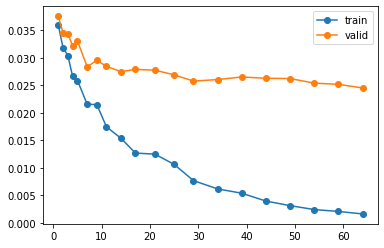

In [16]:
plt.plot(steps, train, 'o-', label="train")
plt.plot(steps, valid, 'o-', label="valid")
# plt.yscale("log")
plt.legend()
plt.savefig(run_name+'_hist.png',dpi=300)

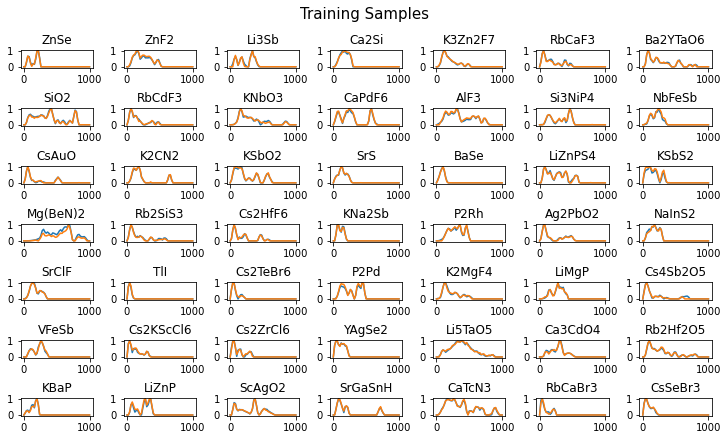

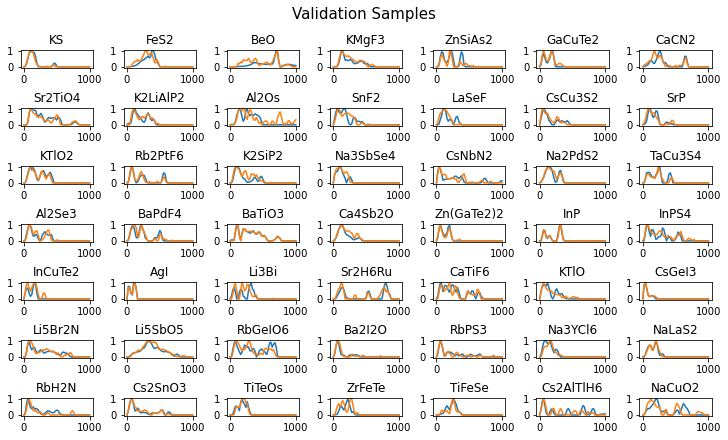

In [17]:
idx1 = np.sort(np.random.choice(index_tr, 49, replace=False)).reshape(7,7)
fig = plt.figure(figsize=(10,6),constrained_layout=True)
gs = fig.add_gridspec(idx1.shape[0], idx1.shape[1])
for row in range(0,idx1.shape[0]):
    for col in range(0,idx1.shape[1]):
        d = torch_geometric.data.Batch.from_data_list([data[idx1[row,col]]])
        d.to(device)
        output = model(d.x, d.edge_index, d.edge_attr, n_norm=n_norm, batch=d.batch)
        ax = fig.add_subplot(gs[row,col])
        ax.plot(phfre, d.y[0].cpu().detach(),label='Truth')
        ax.plot(phfre, output[0].cpu().detach(),'-',label='Prediction')
        ax.set_title(str(cif[idx1[row,col]][1][5:]))
fig.suptitle('Training Samples', horizontalalignment='center', fontsize = 15)
fig.savefig(run_name+'_train.png',dpi=300)

idx2 = np.sort(np.random.choice(index_va, 49, replace=False)).reshape(7,7)
fig = plt.figure(figsize=(10,6),constrained_layout=True)
gs = fig.add_gridspec(idx2.shape[0], idx2.shape[0])
for row in range(0,idx2.shape[0]):
    for col in range(0,idx2.shape[1]):
        d = torch_geometric.data.Batch.from_data_list([data[idx2[row,col]]])
        d.to(device)
        output = model(d.x, d.edge_index, d.edge_attr, n_norm=n_norm, batch=d.batch)
        ax = fig.add_subplot(gs[row,col])
        ax.plot(phfre, d.y[0].cpu().detach(),label='Truth')
        ax.plot(phfre, output[0].cpu().detach(),'-',label='Prediction')
        ax.set_title(str(cif[idx2[row,col]][1][5:]))
fig.suptitle('Validation Samples', horizontalalignment='center', fontsize = 15)
fig.savefig(run_name+'_valid.png',dpi=300)

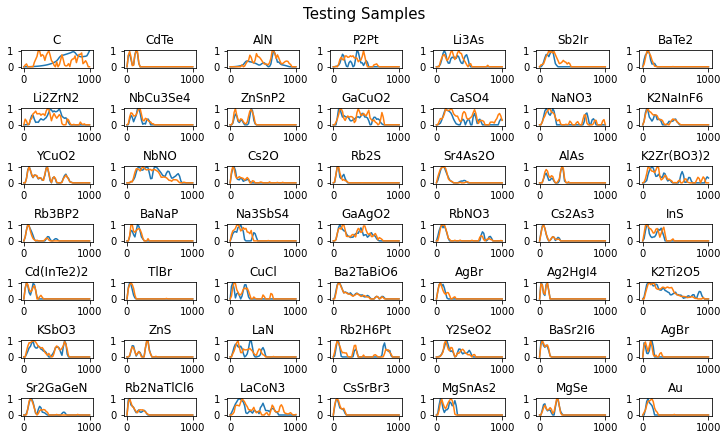

In [18]:
idx3 = np.sort(np.random.choice(index_te, 49, replace=False)).reshape(7,7)
fig = plt.figure(figsize=(10,6),constrained_layout=True)
gs = fig.add_gridspec(idx3.shape[0], idx3.shape[0])
for row in range(0,idx3.shape[0]):
    for col in range(0,idx3.shape[1]):
        d = torch_geometric.data.Batch.from_data_list([data[idx3[row,col]]])
        d.to(device)
        output = model(d.x, d.edge_index, d.edge_attr, n_norm=n_norm, batch=d.batch)
        ax = fig.add_subplot(gs[row,col])
#         ax.plot(phfre_gt[:500], phdos_gt[idx3[row,col],:500], c='0.55',label='Truth')
        ax.plot(phfre, d.y[0].cpu().detach(),label='Truth')
        ax.plot(phfre, output[0].cpu().detach(),'-',label='Prediction')
#         ax.set_title(f'mp-{material_id[idx3[row,col]]}\n{str(cif[idx3[row,col]][1][5:])}')
        ax.set_title(str(cif[idx3[row,col]][1][5:]))
fig.suptitle('Testing Samples', horizontalalignment='center', fontsize = 15)
fig.savefig(run_name+'_test.png',dpi=300)